# Setup

In [3]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [4]:
%matplotlib inline

In [5]:
from relaxed.plot_defaults import *

import numpy as np
import matplotlib.pyplot as plt 

from relaxed.analysis import get_mah, add_box_indices
from relaxed.models import training_suite, prepare_datasets

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
# Data

mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']
q = cat['q']
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [7]:
# prepare catalog with all a_m
names = [f'am_{ii}' for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=names[ii])

In [8]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

info = {
    'cvir_only': {'x': ('cvir', ), 'y': names, },
    'x0_only': {'x': ('x0', ), 'y': names, },
    'eta_only': {'x': ('eta', ), 'y': names, },
    'all': {'x':('cvir', 't/|u|', 'x0', 'spin', 'q'), 'y':names,},
}
datasets, cat_train, cat_test = prepare_datasets(cat, info)

In [9]:
# joint models
data ={
    'linear_cvir': {
        'xy': datasets['cvir_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_x0': {
        'xy': datasets['x0_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_eta': {
        'xy': datasets['eta_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_all': {
        'xy': datasets['all']['train'], 'n_features': 5, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
models = training_suite(data)

In [10]:
# get correlations from predictions 
from scipy.stats import spearmanr
corrs = {} 
sigmas_x ={}
dataset_names = ['cvir_only', 'x0_only', 'eta_only', 'all']
mdl_names  = ['linear_cvir', 'linear_x0', 'linear_eta', 'linear_all']
for dataset_names, mdl_name in zip(dataset_names, mdl_names):
    model = models[mdl_name]
    x_test, y_test = datasets[dataset_names]['test']
    y_pred = model.predict(x_test)
    corrs[mdl_name] = np.array([spearmanr(y_pred[:, jj], y_test[:, jj]).correlation for jj in range(y_pred.shape[1])])
    sigmas_x[mdl_name] = np.array([np.std(y_pred[:, jj] - y_test[:, jj]) / (np.sqrt(2)*np.std(y_test[:, jj])) for jj in range(y_pred.shape[1])])


/Users/imendoza/miniconda3/envs/relaxed/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/imendoza/miniconda3/envs/relaxed/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/imendoza/miniconda3/envs/relaxed/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


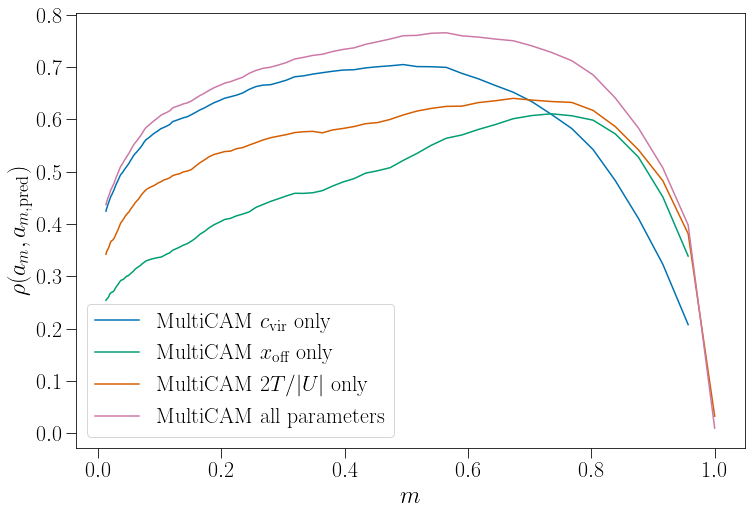

In [12]:
# plots 
plt.figure(figsize=(12, 8))
nice_names = [r'\rm MultiCAM $c_{\rm vir}$ only', 
              r'\rm MultiCAM $x_{\rm off}$ only',
              r'\rm MultiCAM $2T / \vert U \vert$ only',
             r'\rm MultiCAM all parameters']
for nice_name, mdl_name in zip(nice_names, mdl_names):
    plt.plot(mass_bins, corrs[mdl_name], label=nice_name)
plt.xlabel('$m$')
plt.ylabel('$\\rho(a_{m}, a_{m, \\rm{pred}})$')
plt.legend()

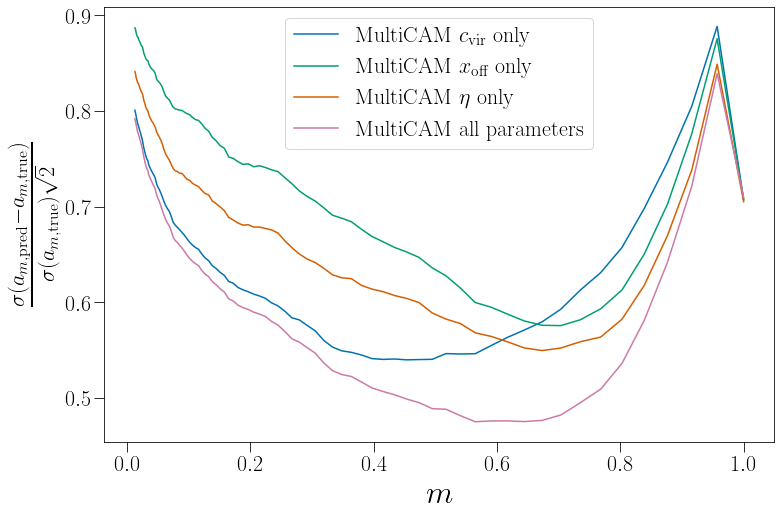

In [13]:
# plots 
plt.figure(figsize=(12, 8))
nice_names = [r'\rm MultiCAM $c_{\rm vir}$ only', 
              r'\rm MultiCAM $x_{\rm off}$ only',
              r'\rm MultiCAM $\eta$ only',
             r'\rm MultiCAM all parameters']
for nice_name, mdl_name in zip(nice_names, mdl_names):
    plt.plot(mass_bins, sigmas_x[mdl_name], label=nice_name)
plt.xlabel('$m$', size=32)
plt.ylabel(r"$\frac{\sigma(a_{m, \rm pred} - a_{m, \rm true})}{ \sigma(a_{m, \rm true}) \sqrt{2}}$", size=32)
plt.legend()